This analysis notebook is for exploring one gene in one cancer type (to reduce possible biases)

TODO: Ploidy Corrected Copy Number

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

### Settings

In [2]:
geneToStudy = 'MYCN'
cancerTypeToStudy = 'Ewing Sarcoma'
# cancerType or cancerTypeDetailed
analysis_type = 'cancerTypeDetailed'
# Use facets called amp (true/false), use false if you do not have the file (external to the pipeline)
use_facets_amp = False

In [3]:
config = "../global_config_bash.rc"

In [4]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [5]:
# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# Merged FACETS cbioportal file
manifest = pd.read_csv(paths['mergedOutputDirectory'] + '/facets_cbioportal_merged_full.tsv', sep = '\t')

if use_facets_amp :
    # facets file per sample. If this file has not been created (Currently not included in this pipeline), set use_facets_amp to False, and don't run the FACETS analysis
    facets = pd.read_csv("../mycn_facets_merged.tsv", sep = '\t', index_col = False)

### Setup

In [6]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

manifest['sampleId'] = manifest['ID']
manifest = manifest[['sampleId', analysis_type, 'osStatus', 'osMonths']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

In [7]:
# Trim dataframe
echo_ctype = echo[echo[analysis_type] == cancerTypeToStudy]

In [8]:
# Add facets amp information if necessary
if use_facets_amp : 
    facets['patientId'] = facets['sample'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])

    facets_gene_amps = {key: "INDETERMINATE" for key in facets['patientId'].unique()}
    for i, row in facets.iterrows() :
        if row['gene'] == geneToStudy :
            facets_gene_amps[row['patientId']] = row['cn_state']

    echo_ctype['facets_amp'] = 'INDETERMINATE'

    for i, row in echo_ctype.iterrows() :
        echo_ctype.loc[i, 'facets_amp'] = facets_gene_amps[row['patientId']]

In [9]:
# create a dataframe just for the one gene in the one cancer type
specific_gene_ctype = pd.DataFrame({'patientId': echo_ctype['patientId'].unique()})
specific_gene_ctype['ecDNA_status'] = False
specific_gene_ctype['osStatus'] = ""
specific_gene_ctype['osMonths'] = np.nan
specific_gene_ctype['amp'] = False
specific_gene_ctype['cn_echo'] = 2

import math

# connect patient IDs to indexes
gene_dict = {}
for i, row in specific_gene_ctype.iterrows() :
    gene_dict[row['patientId']] = i

# Fill in dataframe
for i, row in echo_ctype.iterrows() :
    specific_gene_ctype.loc[gene_dict[row['patientId']], 'osStatus'] = row['osStatus']
    specific_gene_ctype.loc[gene_dict[row['patientId']], 'osMonths'] = row['osMonths']
    if row['gene'] == geneToStudy :
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'cn_echo'] = row['cn']
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'ecDNA_status'] = (row['ecDNA_status'] == 'ecDNA')
        if use_facets_amp :
            if not isinstance(row['facets_amp'], float) :
                if ('AMP' in row['facets_amp']) or ('GAIN' in row['facets_amp']) :
                    amp_status = True
            specific_gene_ctype.loc[gene_dict[row['patientId']], 'amp'] = amp_status
        else :
            specific_gene_ctype.loc[gene_dict[row['patientId']], 'amp'] = True

In [10]:
# Create a combined column that describes ecDNA and amplification status
specific_gene_ctype['combined_status'] = ''
for i, row in specific_gene_ctype.iterrows() :
    if row['ecDNA_status'] and row['amp'] :
        specific_gene_ctype.loc[i, 'combined_status'] = "ecDNA & amp"
    elif row['ecDNA_status'] and not row['amp'] :
        specific_gene_ctype.loc[i, 'combined_status'] = "ecDNA & no amp"
    elif not row['ecDNA_status'] and row['amp'] :
        specific_gene_ctype.loc[i, 'combined_status'] = "no ecDNA & amp"
    else :
        specific_gene_ctype.loc[i, 'combined_status'] = "no ecDNA & no amp"


### KM and Cox Models

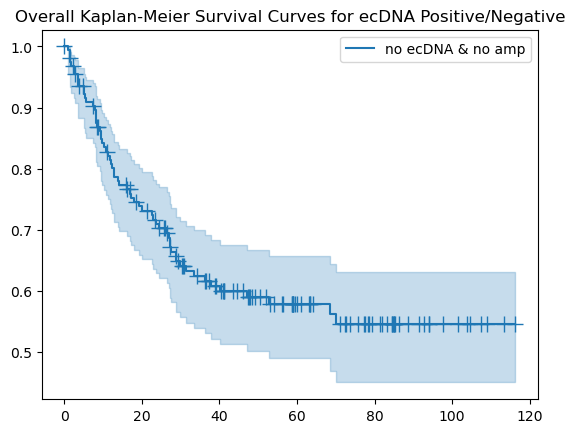

In [11]:
from lifelines import KaplanMeierFitter

specific_gene_ctype_nona = specific_gene_ctype.dropna(subset = ['combined_status', 'osMonths', 'osStatus'])

kmf = KaplanMeierFitter()
for status in specific_gene_ctype_nona['combined_status'].unique():

    subset = specific_gene_ctype_nona[specific_gene_ctype_nona['combined_status'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['osStatus'] == 'DECEASED'))

    kmf.plot(show_censors=True, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA Positive/Negative')
plt.xlabel("")
plt.legend()

Pairwise p-values

In [11]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = specific_gene_ctype_nona['combined_status'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = specific_gene_ctype_nona[specific_gene_ctype_nona['combined_status'] == group1]
    group2_data = specific_gene_ctype_nona[specific_gene_ctype_nona['combined_status'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['osMonths'], event_observed=(group1_data['osStatus'] == 'DECEASED'))
    kmf2.fit(group2_data['osMonths'], event_observed=(group2_data['osStatus'] == 'DECEASED'))
    
    # Perform log-rank test
    result = logrank_test(group1_data['osMonths'], group2_data['osMonths'], event_observed_A=(group1_data['osStatus'] == 'DECEASED'), event_observed_B=(group2_data['osStatus'] == 'DECEASED'))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

In [12]:
p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,no ecDNA & no amp,no ecDNA & amp
ecDNA & amp,0.070596,0.832533
no ecDNA & no amp,,0.074142


In [13]:
# A cox model for ecDNA status and amp
gene_cox = specific_gene_ctype.dropna(subset = ['osMonths', 'osStatus', 'ecDNA_status', 'amp'])
gene_cox['eventOccurred'] = (gene_cox['osStatus'] == 'DECEASED').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'eventOccurred', 'amp', 'ecDNA_status']
cox.fit(gene_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
cox.print_summary()
print(cox.summary)

/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_59988/1395399748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_cox['eventOccurred'] = (gene_cox['osStatus'] == 'DECEASED').astype(int)


<lifelines.CoxPHFitter: fitted with 454 total observations, 349 right-censored observations>
             duration col = 'osMonths'
                event col = 'eventOccurred'
      baseline estimation = breslow
   number of observations = 454
number of events observed = 105
   partial log-likelihood = -539.64
         time fit was run = 2024-07-05 16:22:23 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
amp           0.55      1.73      0.36           -0.15            1.25                0.86                3.48
ecDNA_status -0.13      0.88      0.39           -0.90            0.64                0.41                1.90

              cmp to     z    p  -log2(p)
covariate                                
amp             0.00  1.55 0.12      3.04
ecDNA_status    0.00 -0.33 0.74      0.43
---
Concordance = 0.59
Partial AIC = 1083.29
log-likelihood ratio test = 4.50 on 2 df
-log2(p) of ll-ratio test = 3.25

                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
amp           0.550457   1.734045  0.355510       -0.146329        1.247243   
ecDNA_status -0.128290   0.879598  0.393314       -0.899172        0.642592   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
amp                      0.863873             3.480734     0.0  1.548361   
ecDNA_status             0.406907             1.901403     0.0 -0.326177   

                     p  -log2(p)  
covariate                         
amp           0.121535  3.040550  
ecDNA_status  0.744291  0.426062  


### Facets Analysis

In [14]:
# create dictionaries for segment lengths and which samples are amplified
segment_lengths = {}
facets_amps = {}
for i, row in facets.iterrows() :
    if isinstance(row['cn_state'], str) :
        segment_lengths[row['sample']] = row['seg_length']
        if "AMP" in row['cn_state'] :
            facets_amps[row['sample']] = True

In [15]:
# Make a dataframe to analyze
facets_lengths_df = facets[['sample', 'seg_length', 'tcn']]

# These are the samples to use
ctype_sampleIds = {}
# These are for labeling ecDNA pos and neg (to get rid of na ones)
ecDNA_pos = {}
ecDNA_neg = {}
for i, row in echo_ctype.iterrows() :
    if row[analysis_type] == cancerTypeToStudy :
        ctype_sampleIds[row['tumorSampleId']] = True
        if row['tumorSampleId'] in facets_amps :
            if row['ecDNA_status'] == 'ecDNA' :
                ecDNA_pos[row['tumorSampleId']] = True
            if row['ecDNA_status'] == 'non-ecDNA' :
                ecDNA_neg[row['tumorSampleId']] = True
facets_lengths_df = facets_lengths_df[facets_lengths_df['sample'].isin(ctype_sampleIds)]

In [16]:
# Label the ones that are not called na
facets_lengths_df['ecDNA'] = np.nan

for i, row in facets_lengths_df.iterrows() :
    if row['sample'] in ecDNA_pos :
        facets_lengths_df.loc[i, 'ecDNA'] = True
    if row['sample'] in ecDNA_neg :
        facets_lengths_df.loc[i, 'ecDNA'] = False


/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_59988/1250506428.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  facets_lengths_df.loc[i, 'ecDNA'] = True


Segment size vs copy number for those called amplified in both FACETS and ECHO, uses FACETS called copy numbers

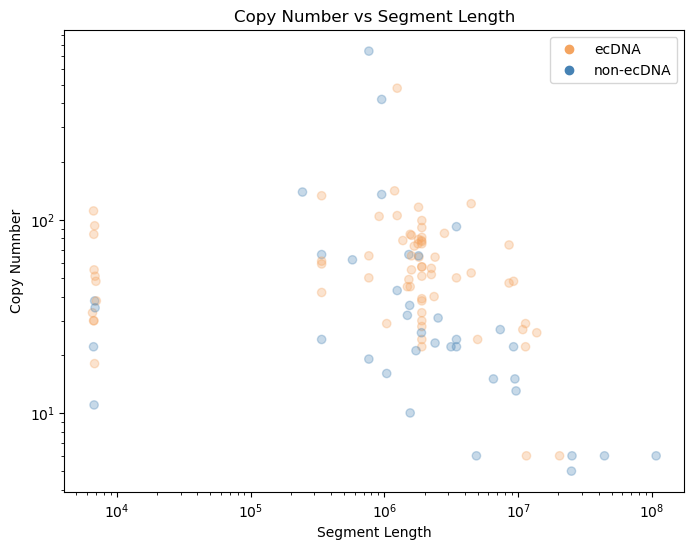

In [17]:
facets_lengths_df_nona = facets_lengths_df.dropna()

facets_amp = facets_lengths_df_nona

# Define colors for each category
color_map = {True: 'sandybrown', False: 'steelblue'}

# Create a list of colors based on the 'ecDNA' column
colors = facets_amp['ecDNA'].map(color_map)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(facets_amp['seg_length'], facets_amp['tcn'], c=colors, label=facets_amp['ecDNA'], alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Copy Numnber')
plt.xlabel('Segment Length')
plt.title("Copy Number vs Segment Length")

legend_labels = ['ecDNA', 'non-ecDNA']
legend_colors = ['sandybrown', 'steelblue']
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
plt.legend(markers, legend_labels, loc='upper right')

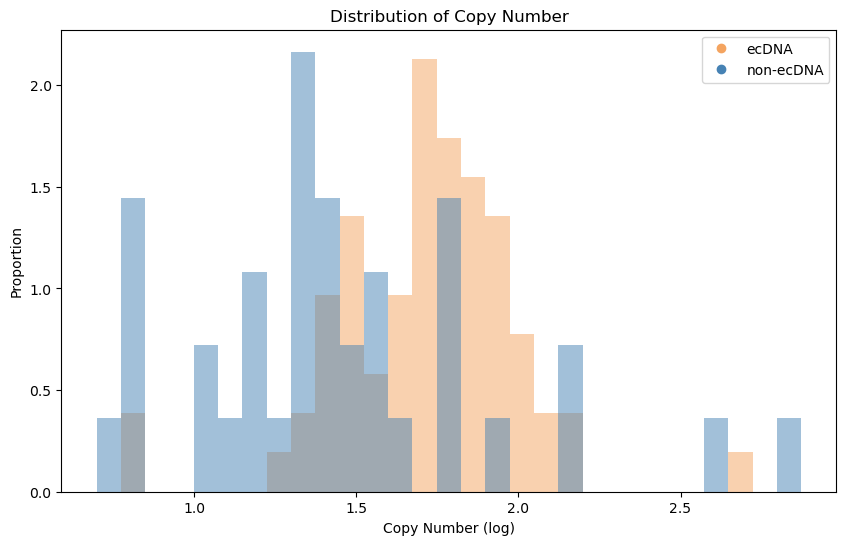

In [18]:
# Separate data for ecDNA and non-ecDNA
ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == True]['tcn']
log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]

non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == False]['tcn']
log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]

# Plotting histograms on logarithmic scale
plt.figure(figsize=(10, 6))
bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
# Histogram for ecDNA = ecDNA
plt.hist(log_ecDNA, alpha=0.5, bins = bins, color='sandybrown', label='ecDNA', density = True)

# Histogram for ecDNA = non-ecDNA
plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color='steelblue', label='non-ecDNA', density = True)

# Customize the plot
plt.title('Distribution of Copy Number')
plt.xlabel('Copy Number (log)')
plt.ylabel('Proportion')

legend_labels = ['ecDNA', 'non-ecDNA']
legend_colors = ['sandybrown', 'steelblue']
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
plt.legend(markers, legend_labels, loc='upper right')

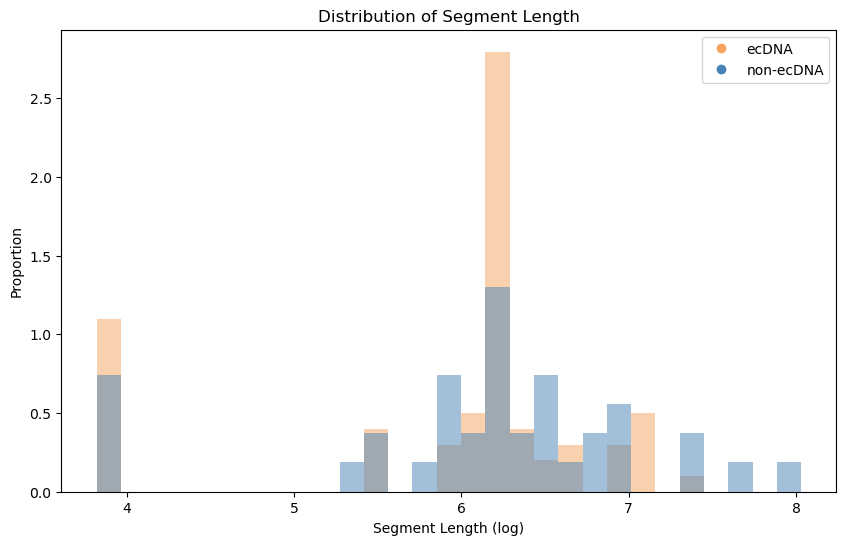

In [19]:
# Separate data for ecDNA and non-ecDNA
ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == True]['seg_length']
log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]

non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == False]['seg_length']
log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]

# Plotting histograms on logarithmic scale
plt.figure(figsize=(10, 6))
bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
# Histogram for ecDNA = ecDNA
plt.hist(log_ecDNA, alpha=0.5, bins = bins, color='sandybrown', label='ecDNA', density = True)

# Histogram for ecDNA = non-ecDNA
plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color='steelblue', label='non-ecDNA', density = True)

# Customize the plot
plt.title('Distribution of Segment Length')
plt.xlabel('Segment Length (log)')
plt.ylabel('Proportion')

legend_labels = ['ecDNA', 'non-ecDNA']
legend_colors = ['sandybrown', 'steelblue']
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
plt.legend(markers, legend_labels, loc='upper right')
